In [1]:
import functools
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
df = pd.read_csv('/mnt/1BC89B39470CFFE8/Workstation/PhotoRater/unsplash-research-dataset-lite-latest/photos.tsv000', sep='\t', header=0)

In [4]:
df["stats_views"].describe()

count    2.500000e+04
mean     1.394069e+06
std      2.927277e+06
min      2.831700e+04
25%      2.539570e+05
50%      5.477885e+05
75%      1.114180e+06
max      1.003223e+08
Name: stats_views, dtype: float64

In [5]:
mean = df["stats_views"].mean()
std = df["stats_views"].std()

In [6]:
record_defaults = [tf.string, tf.float32]
dataset = tf.data.experimental.CsvDataset(
    '/mnt/1BC89B39470CFFE8/Workstation/PhotoRater/unsplash-research-dataset-lite-latest/photos.tsv000', 
    record_defaults,
    field_delim="\t",
    select_cols=[0, 19],
    header=True)

In [7]:
dataset

<CsvDatasetV2 shapes: ((), ()), types: (tf.string, tf.float32)>

In [8]:
for line in dataset.take(10):
  print(line)

(<tf.Tensor: shape=(), dtype=string, numpy=b'r3ZWnitp3zk'>, <tf.Tensor: shape=(), dtype=float32, numpy=961314.0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'-Y-XzY0HhEM'>, <tf.Tensor: shape=(), dtype=float32, numpy=9014666.0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'mwhklqGVzck'>, <tf.Tensor: shape=(), dtype=float32, numpy=13289509.0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'HZg0vJHFyg0'>, <tf.Tensor: shape=(), dtype=float32, numpy=1517759.0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'8CDzJFF10d0'>, <tf.Tensor: shape=(), dtype=float32, numpy=1685804.0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'j2HQKlLFT_c'>, <tf.Tensor: shape=(), dtype=float32, numpy=2111610.0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'GfuxOPaitSs'>, <tf.Tensor: shape=(), dtype=float32, numpy=1246145.0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'2KXEb_8G5vo'>, <tf.Tensor: shape=(), dtype=float32, numpy=26365732.0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'x6RO8lNSzpo'>, <tf.Tensor: shape=(

In [9]:
def transform(photo_id, stats_views):
    label = ((stats_views - mean) / std + 0.5)
    if label > 1.0:
        label = tf.constant(1.0, dtype=tf.float32)
    elif label < 0.0:
        label = tf.constant(0.0, dtype=tf.float32)
    filename = "/mnt/1BC89B39470CFFE8/Workstation/PhotoRater/data/" + photo_id + ".jpg"
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

In [10]:
images_ds = dataset.map(transform)

In [11]:
def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy())
  plt.axis('off')

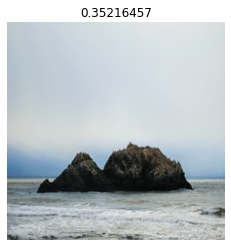

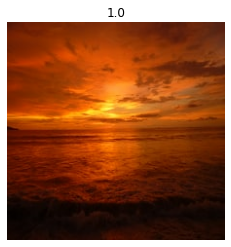

In [12]:
for image, label in images_ds.take(2):
  show(image, label)

In [13]:
for line in images_ds.take(10):
  print(line[1].numpy())

0.35216457
1.0
1.0
0.5422542
0.5996608
0.7451223
0.44946694
1.0
0.5811856
0.7106715


In [14]:
import tensorflow_hub as hub

from tensorflow.keras import layers

In [15]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 

In [16]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [17]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.Huber(),
  metrics=['mse', 'mae'])

In [19]:
val_size = int(25000 * 0.2)
train_ds = images_ds.skip(val_size)
val_ds = images_ds.take(val_size)

In [20]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=10)
    ds = ds.batch(256)
    ds = ds.prefetch(buffer_size=10)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [21]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100)

Epoch 1/100


ResourceExhaustedError:  OOM when allocating tensor with shape[1024,96,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/keras_layer/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/predict/MobilenetV2/expanded_conv_1/expand/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_16930]

Function call stack:
train_function


In [22]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/saved_models/1597667390/assets
INFO:tensorflow:Assets written to: /tmp/saved_models/1597667390/assets


In [23]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_path)
tflite_model = converter.convert()
open(f"{export_path}.tflite", "wb").write(tflite_model)

8939584